In [1]:
from final_2016 import pass_data
from graph_util import *

/Users/manik/.pyenv/versions/3.8.0/lib/python3.8/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf 
import matplotlib.pyplot as plt 
from datetime import datetime
from datetime import timedelta
import copy
from scipy.special import expit
from torch import cholesky

import torch

import pyro
import pyro.distributions as dist

from pyro.infer import Predictive
from pyro.infer import MCMC, NUTS

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from matplotlib import pyplot
from statsmodels.graphics.regressionplots import abline_plot

from collections import defaultdict
import seaborn as sns

import plotnine as p9
from plotnine import *
from tqdm.notebook import tqdm

import dill

## Goals

Our goals are two-fold:
  1. is to translate The Economist's presidential election prediction model from R & Stan to Python & Pyro
  2. is to do a thorough evaluation of the results generated by the model and inference methods we have translated from the previous goal

## Model

#### Abramovitz "Time for Change" Model

national_mu_prior = $x_0 + x_1 \cdot \text{juneapp} + x_2 \cdot \text{q2gdp}$

In [3]:
data, polls, res, dfTemp, ev = pass_data()

                            OLS Regression Results                            
Dep. Variable:                incvote   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     25.15
Date:                Sun, 29 Nov 2020   Prob (F-statistic):           1.62e-05
Time:                        08:39:18   Log-Likelihood:                -41.736
No. Observations:                  18   AIC:                             89.47
Df Residuals:                      15   BIC:                             92.14
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     49.6070      0.835     59.386      0.0

/Users/manik/.pyenv/versions/3.8.0/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18


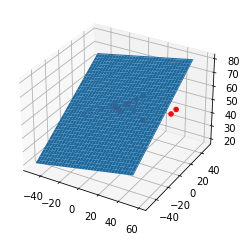

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dfTemp['juneapp'], dfTemp['q2gdp'], dfTemp['incvote'], c='r', marker='o')

coefs = res.params
xs = np.tile(np.arange(101), (101,1)) - 50
ys = np.tile(np.arange(101), (101,1)).T - 50
national_mu_prior =  coefs["Intercept"] + coefs["juneapp"] * xs + coefs["q2gdp"] * ys

ax.plot_surface(xs,ys,national_mu_prior)
plt.show()

A common critisim for Fundamental Models as explained by Economist is that they provide a close match to historical data and thus fail to capture the future given the current election polling data

### Dynamic Bayesian Model w. Polling & Abramovitz Data

- The Bayesian network used works on relating the variables to each other over adjacent time step (days till election)
- The model observe the state and national polls that are conducted till the election day 

$y_i^d \sim Binom(n_i, \pi_{i,j}^d)$ 

$logit(\pi_{i,j}^d) = \mu_b[t,s] + Bias(pollster, state\ population, poll\ mode, measuring)$

where, <br />
&nbsp;&nbsp; $y_i^d$ - no of dem. supportors <br />
&nbsp;&nbsp; $n_i$ - Total responders to poll <br />
&nbsp;&nbsp; $\pi_{i,j}^d$ - share of dem votes <br />
&nbsp;&nbsp; $\mu_b[t,s]$ - s state component on day t

- It uses the Abramovitz model as the prior for the $\mu_b$ values and uses reverse random walk to relate over time with polls

$\mu_b[t-1, s] \sim Normal(\mu_b[t,s]) $

As a result the election day prediction is given by
$logit^{-1}(\mu_b[t,s])$

In [5]:
from poll_model import model, Inference_MCMC, sample_posterior_predictive, predicted_score

### Inference

Here we are using the pass_data( ) function from our final_2016.py helper python file in order to abstract the extensive & dull data preprocessing needed before feeding into the model. We use the NUTS paradigm to help explore our vast data set in a more efficient manner; otherwise we would not be able to tractably estimate the posterior. 

In [6]:
numSamples = 100
numChains = 6

In [7]:
posterior_samples, hmc_samples = Inference_MCMC(model, data,
                                                polls, numSamples,
                                                numSamples, numChains)

### Posterior Predictive

This gives us the samples that are conditioned on the posterior distribution of the latent variable model so that we can extract the predicted variables such as mu_b and thereafter evaluate the model.

In [8]:
posterior_predictive = sample_posterior_predictive(model,
                                                   posterior_samples,
                                                   numSamples*numChains, data)

### Predicted Probability

In [9]:
predicted = predicted_score(posterior_predictive, numSamples*numChains, data)

In [10]:
vals = predicted[:,90,:]

In [11]:
preds = createPredictionsDict(vals)

In [12]:
swing_states = ["OH", "WI", "MI", "FL", "GA", "PA", "IA", "AZ"]
EV, EV_Index = ev["EV"], ev["EV_Index"]
numDays = len(preds[0])
numStates = len(preds)
EV_list_trump = list()
EV_list_clinton = list()


out = electoralVoteCalculator(numDays, numStates,
                        preds, EV_Index, EV)
cWins, tWins, EV_T, EV_C = out[0], out[1], out[2], out[3]

In [13]:
ind_list = [list(EV.keys()).index(s) for s in swing_states]

/Users/manik/.pyenv/versions/3.8.0/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
/Users/manik/.pyenv/versions/3.8.0/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
/Users/manik/.pyenv/versions/3.8.0/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

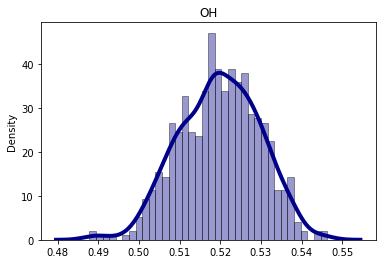

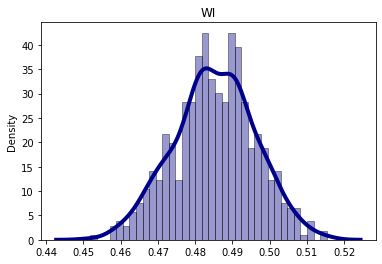

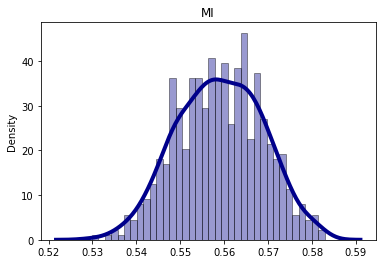

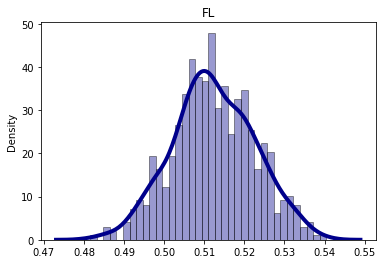

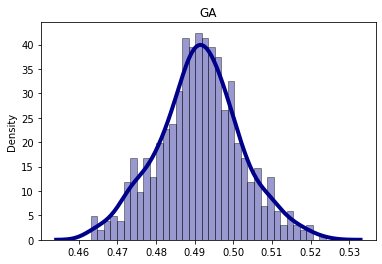

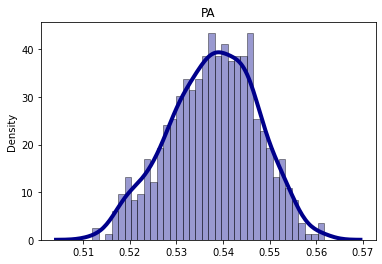

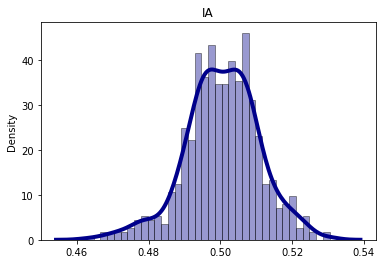

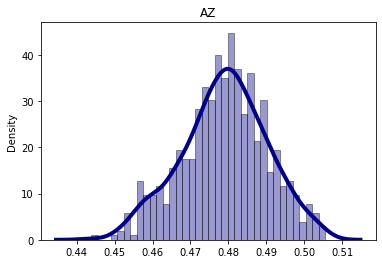

In [14]:
for i in ind_list:
    plt.figure()
    sns.distplot(preds[i], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}).set_title(EV_Index[i])

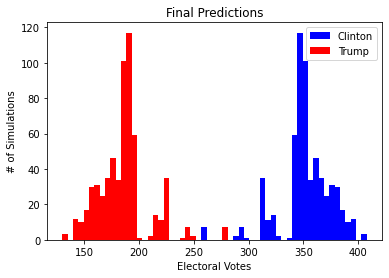

In [15]:
plt.hist(EV_C, bins='auto', color = 'b')
plt.hist(EV_T, bins='auto', color = 'r')
plt.legend(['Clinton', 'Trump'])
plt.xlabel("Electoral Votes")
plt.ylabel("# of Simulations")
plt.title("Final Predictions")
plt.show()

In [16]:
cWinsList, tWinsList = [], []
EV_C_mu, EV_T_mu = [], []
EV_C_std, EV_T_std = [], []

EV_C_mu, EV_C_std, EV_T_mu, EV_T_std, cWinsList, tWinsList =\
    generate_mu_sigma(EV_C_mu, EV_C_std, EV_T_mu, EV_T_std,
                      cWinsList, tWinsList, predicted, 
                      numDays, numStates, EV_Index, EV)

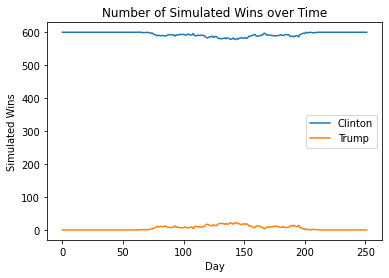

In [17]:
sns.lineplot(data=np.array(cWinsList))
sns.lineplot(data=np.array(tWinsList))
plt.legend(['Clinton', 'Trump'])
plt.xlabel("Day")
plt.ylabel("Simulated Wins")
plt.title("Number of Simulated Wins over Time")
plt.show()

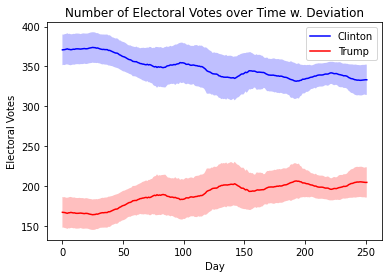

In [18]:
plot_ev_over_time(EV_C_mu, EV_C_std, EV_T_mu, EV_T_std)

In [19]:
states = list(EV.keys())

In [20]:
mu_b_prior = data['mu_b_prior']
state_covariance_mu_b_T = data['state_covariance_mu_b_T']
mu_b_prior_draws = np.random.multivariate_normal(mu_b_prior, state_covariance_mu_b_T, 1000)
mu_b_prior_df = mean_low_high(mu_b_prior_draws, states, 'prior')

In [21]:
mu_b_posterior_draws = posterior_predictive['mu_b'].squeeze()[:,:,-1]
mu_b_posterior_df = mean_low_high(mu_b_posterior_draws, states, 'posterior')
mu_b_posterior_df['color'] = mu_b_posterior_df['mean']>0.5

idx = mu_b_posterior_df["states"].isin(swing_states)
mu_b_posterior_df[idx][['states', 'mean', 'high', 'low']]

,states,mean,high,low
2,AZ,0.461876,0.477214,0.446610
9,FL,0.506799,0.522717,0.490867
10,GA,0.479634,0.493666,0.465634
15,IA,0.493309,0.508132,0.478497
22,MI,0.547508,0.562558,0.532371
35,OH,0.505996,0.520933,0.491048
38,PA,0.532486,0.546688,0.518231
49,WI,0.484339,0.501313,0.467402


In [22]:
mu_b_df = pd.concat([mu_b_prior_df, mu_b_posterior_df])

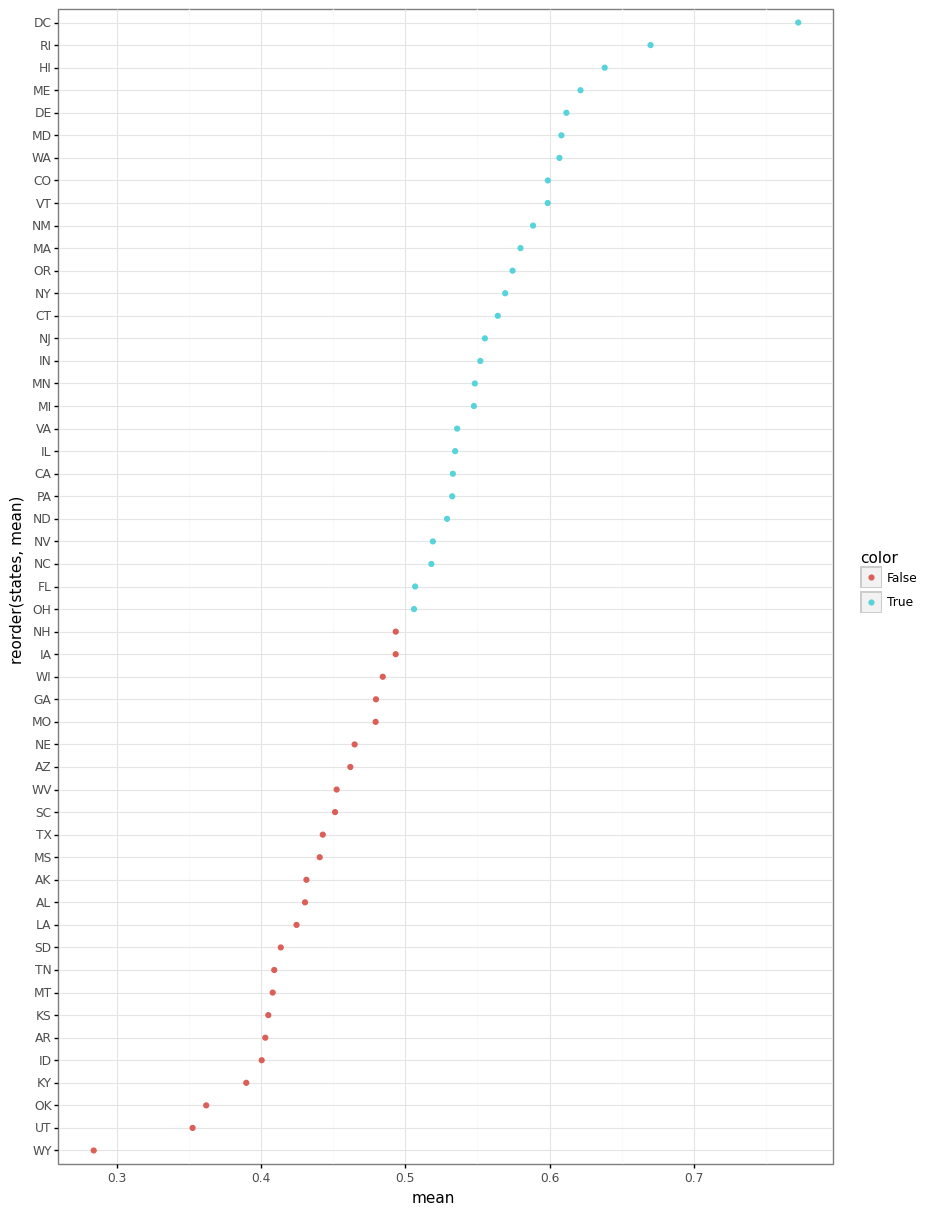

<ggplot: (328947851)>

In [23]:
p9.options.figure_size = (10, 15)
(
    ggplot(mu_b_posterior_df) +
    geom_point(aes(y = 'mean', x = 'reorder(states, mean)', color='color'), position = position_dodge(width = 0.5)) +
    coord_flip() +
    theme_bw()
 )

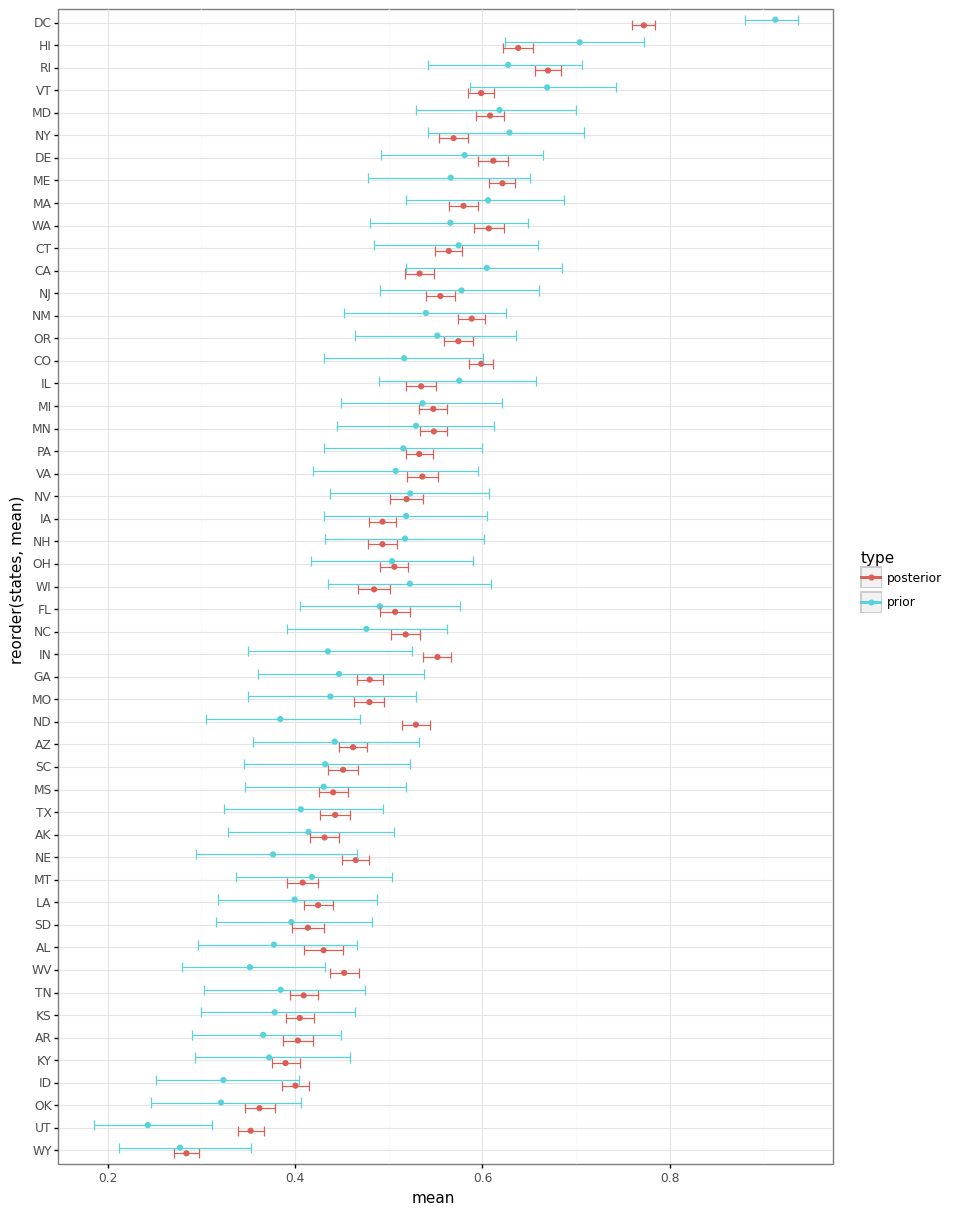

<ggplot: (328592339)>

In [24]:
p9.options.figure_size = (10, 15)
(
    ggplot(mu_b_df) +
    geom_point(aes(y = 'mean', x = 'reorder(states, mean)', color='type'), position = position_dodge(width = 0.5)) +
    geom_errorbar(aes(ymin = 'low', ymax = 'high', x = 'states', color='type'), width = 0, position = position_dodge(width = 0.5)) +
    coord_flip() +
    theme_bw()
 )

In [25]:
pct_clinton = function_tibble(0, predicted)
for i in range(1, predicted.shape[2]):
    temp = function_tibble(i, predicted)
    pct_clinton = pd.concat([pct_clinton, temp])
pct_clinton['state'] = pct_clinton['state'].apply(lambda x: states[x])

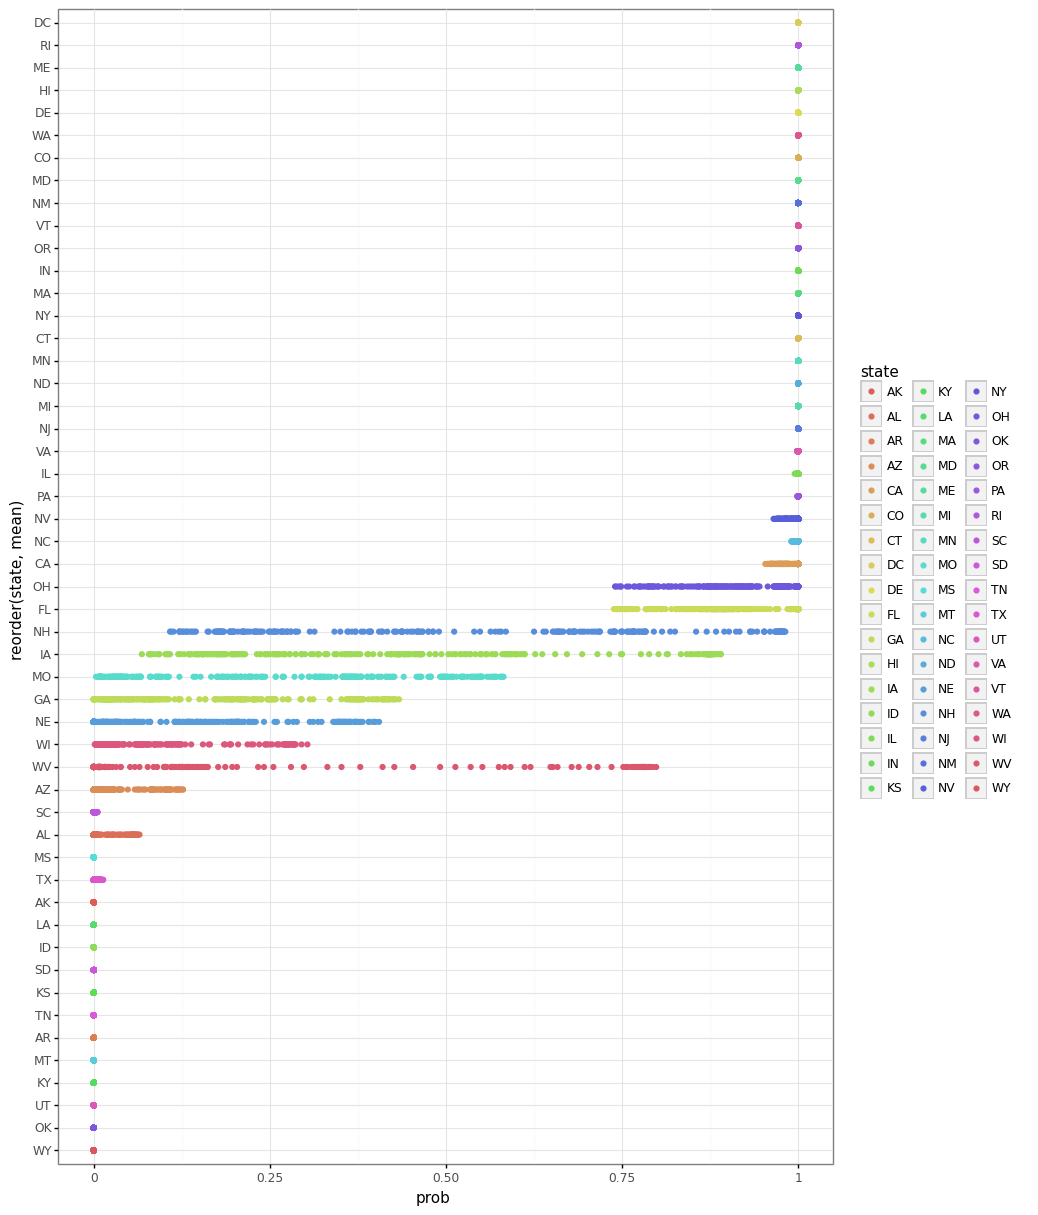

<ggplot: (328964633)>

In [26]:
p9.options.figure_size = (10, 15)
(
    ggplot(pct_clinton) +
    geom_point(aes(y = 'prob', x = 'reorder(state, mean)', color='state'), position = position_dodge(width = 0.5)) +
    coord_flip() +
    theme_bw()
 )

In [27]:
cols = ['state', 'year', 'dem']
results = pd.read_csv("../data/potus_results_76_16.csv", usecols=cols)
results = results.loc[results['year'] == 2016][['state','dem']].reset_index().drop(columns=['index'])
results = results.rename(columns={'state': 'states', 'dem':'mean'})
results['type'] = ['result']*len(states)

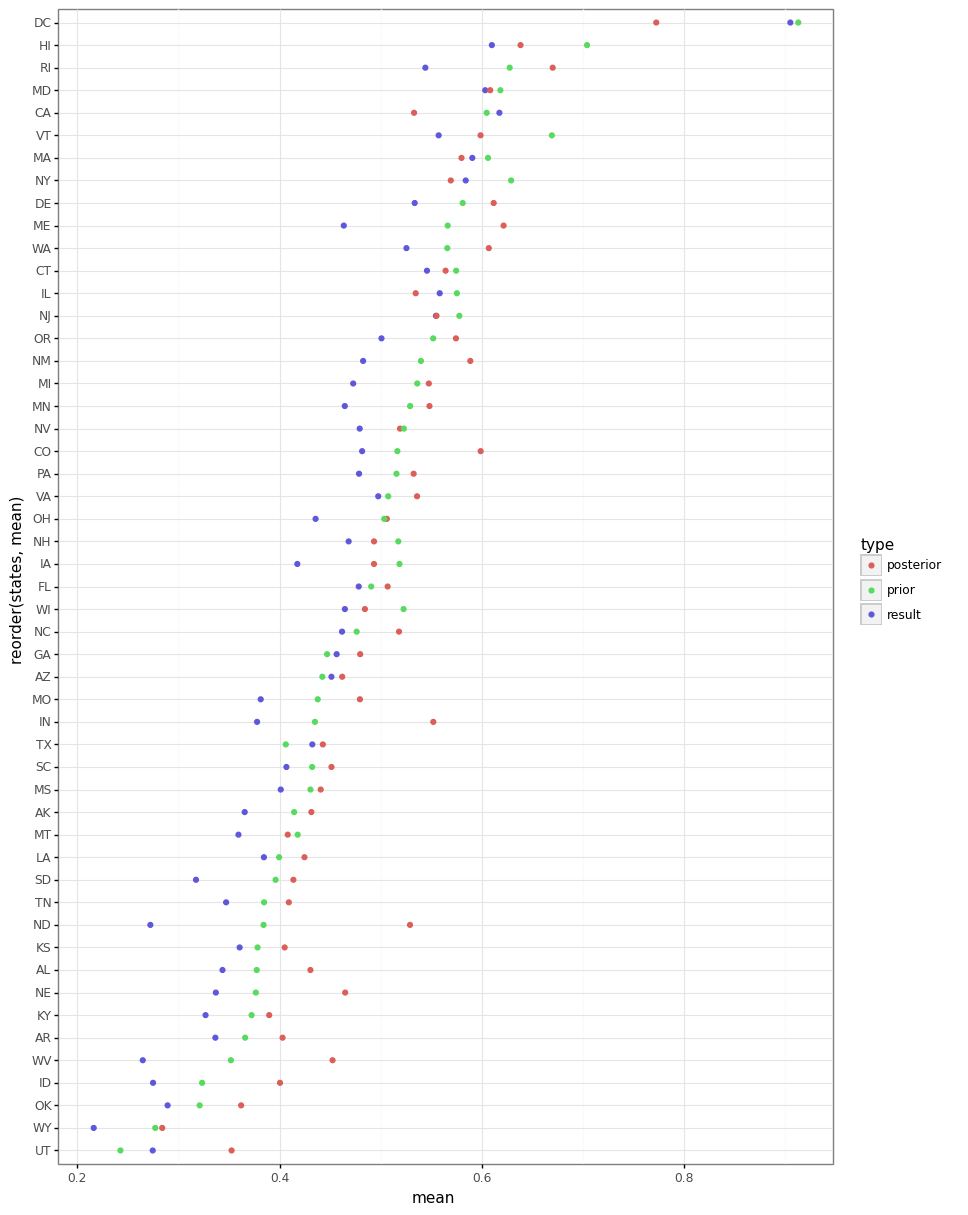

<ggplot: (329070632)>

In [28]:
p9.options.figure_size = (10, 15)
(
    ggplot(pd.concat([results, mu_b_posterior_df, mu_b_prior_df])) +
    geom_point(aes(y = 'mean', x = 'reorder(states, mean)', color='type')) +
    coord_flip() +
    theme_bw()
 )